# 1.Data Cleaning

In [306]:
%reload_ext autoreload
%autoreload 2
import os
import json
import numpy as np
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, pearsonr, ttest_ind, spearmanr
from scipy.interpolate import interp1d, PchipInterpolator
from glob import glob
from datetime import datetime
from IPython.display import clear_output
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from B_dataprocessing import *
from B_DNN_model import *
from B_plotting import *

## 1.1Raw Data

In [51]:
all_metrics_df,testParamDf = data_generation()

Unique DODs 18
Unique discharging_protocol 23
Unique charging_protocol 47
8
12
5


In [119]:
test_coef = ["0","2","3","4","exponential"]
func_coef = ["raw","second","third","forth","exponential"]
for i in range(len(test_coef)):
    globals()[f'X{test_coef[i]}'],globals()[f'y{test_coef[i]}'],globals()[f'Y{test_coef[i]}'],globals()[f'X_Y_merged{test_coef[i]}'] = \
        eval(func_coef[i]+"_order_poly_fitting(all_metrics_df,testParamDf)")


Optimization terminated successfully.
         Current function value: 0.672813
         Iterations: 56
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 4.511265
         Iterations: 62
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 5.299502
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 5.178829
         Iterations: 62
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 5.378137
         Iterations: 73
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 2.112614
         Iterations: 56
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 1.476196
         Iterations: 64
         Function evaluations: 123
Optimization terminated suc

/Users/yeyangzu/Documents/4. Career/Stanford/Courses/CS/CS230/Project/Git/Stanford_Battery_Project/Final_Project_Git_Code/B_dataprocessing.py:226: RuntimeWarning: invalid value encountered in double_scalars
  rms_exp = lambda beta, x, y: np.sqrt(np.sum(np.square((f_exp(beta,x)-y))) / len(y)) * 100 * len(y) / np.sum(y)


Optimization terminated successfully.
         Current function value: 3.414585
         Iterations: 47
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 0.767347
         Iterations: 58
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 1.607724
         Iterations: 63
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 0.967678
         Iterations: 66
         Function evaluations: 126
Optimization terminated successfully.
         Current function value: 1.080581
         Iterations: 70
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 1.368688
         Iterations: 66
         Function evaluations: 128
Optimization terminated successfully.
         Current function value: 1.374236
         Iterations: 62
         Function evaluations: 117
Optimization terminated succ

# Version


### Label Ouput Y with cell keys

In [419]:
version = 'e'
X,y,Y,X_Y_merged = eval('X'+version),eval('y'+version),eval('Y'+version),eval('X_Y_merged'+version)
objective = eval('objective_'+version)
#key_parameters
y_matrix_key = np.array([k for k,v in Y.items()]).reshape(-1,1)
y_selected_key = y_matrix_key.squeeze()
#y with key column
y_with_key = np.append(y, y_matrix_key, axis = 1)

NameError: name 'objective_e' is not defined

## 1.3 Y visualization -> Linear Scaling

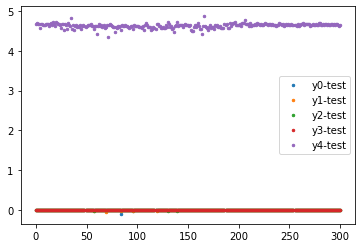

In [ ]:
x_ax = range(len(X))
_,num_outputs = y.shape
for i in range(num_outputs):
    plt.scatter(x_ax, y[:,i],  s=6, label=f"y{i}-test")
plt.legend()
plt.show()

ValueError: x and y must be the same size

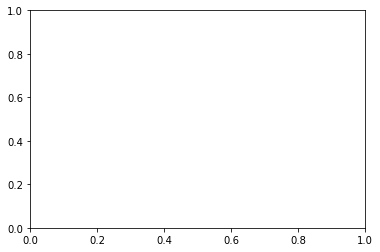

In [420]:
for i in range(num_outputs):
    plt.scatter(x_ax, (y[:,i]-min(y[:,i]))/(max(y[:,i])-min(y[:,i])),  s=6, label=f"y{i}-test")
plt.legend()

plt.legend()
plt.show()

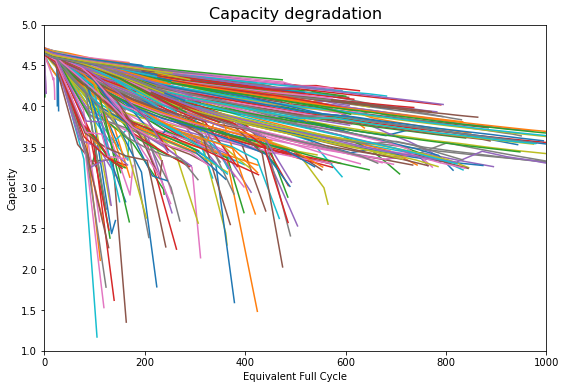

In [ ]:
#empirical data
l=1000
d=1
plt.figure(figsize=(9,6))
plot_empirical(l,d,all_metrics_df)

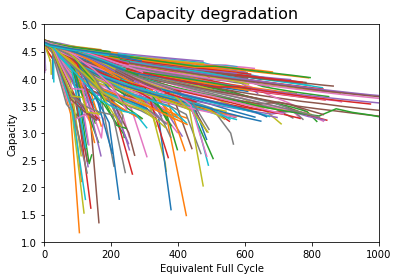

In [ ]:
#selected empirical data
plot_empirical_selected(y_selected_key,l,d,all_metrics_df)

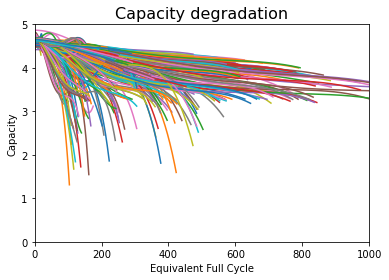

In [ ]:
#selected fitting data
l = 1000
w = 0
plot_curve_pred(y_with_key,y_selected_key,l,w,all_metrics_df,objective)

## 1.4 Correlation Map

In [ ]:
#correlation_heatmap(X_Y_merged,testParamDf)

# 2. Train the model

In [ ]:
#full gamma
X_train,X_test,y_train_coef,y_test_coef,y_train,y_test,y_train_norm,y_test_norm=data_split(X,y_with_key)

#mae
model0 = sequential_model(50,32,'mae',X_train,y_train)
model0.summary()

6
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 50)                550       
_________________________________________________________________
dense_43 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 165       
Total params: 2,347
Trainable params: 2,347
Non-trainable params: 0
_________________________________________________________________


# 3.Prediction

In [421]:
#no validation
lr_model_history_no_val = model0.fit(X_train, y_train_norm, 
                        epochs=100, 
                        verbose=0)

raw_y_pred = model0.predict(X_test)
y_pred = recover(raw_y_pred,y_train)
var_num = y_pred.shape[1]
for i in range(var_num):
    print(f"y{i}MSE:%.4f" % mean_squared_error(y_test[:,i], y_pred[:,i]))

y0MSE:0.0001
y1MSE:0.0000
y2MSE:0.0000
y3MSE:0.0000
y4MSE:0.0022


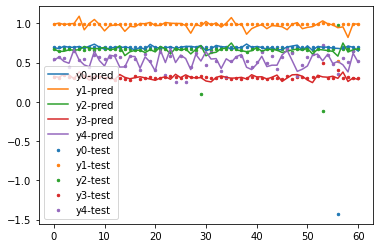

In [422]:
x_ax = range(len(X_test))
for i in range(var_num):
    plt.scatter(x_ax, y_test_norm[:,i],  s=6, label=f"y{i}-test")
    plt.plot(x_ax, raw_y_pred[:,i], label=f"y{i}-pred")
plt.legend()
plt.show()

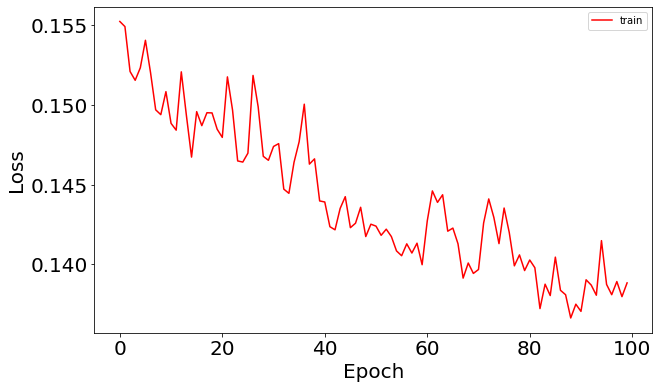

In [423]:
# Plot the loss function with no val
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history_no_val.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

## (DONT"t RUN UNLESS NEEDED) What if we add validation part?

In [424]:
'''python
# Plot the loss function
lr_model_history = model0.fit(X_train, y_train_norm, 
                            epochs=100, 
                            verbose=0,
                            validation_data=(X_test, y_test_norm))

y_pred = model0.predict(X_test)*y_train.max(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)
'''

"python\n# Plot the loss function\nlr_model_history = model0.fit(X_train, y_train_norm, \n                            epochs=100, \n                            verbose=0,\n                            validation_data=(X_test, y_test_norm))\n\ny_pred = model0.predict(X_test)*y_train.max(axis=0)\n\nfig, ax = plt.subplots(1, 1, figsize=(10,6))\nax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')\nax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')\nax.set_xlabel(r'Epoch', fontsize=20)\nax.set_ylabel(r'Loss', fontsize=20)\nax.legend()\nax.tick_params(labelsize=20)\n"

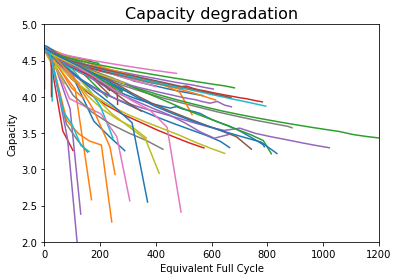

In [425]:
test_key = y_test_coef[:,-1]
l = 1200
w = 2
plot_empirical_selected(test_key,l,w,all_metrics_df)
#真实

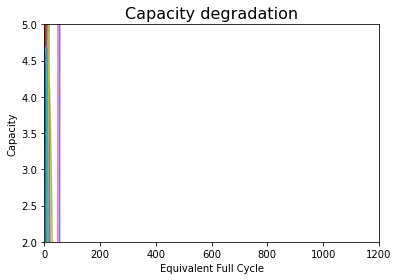

In [426]:
y_with_key_test = np.append(y_pred, test_key.reshape(-1,1), axis = 1)
plot_curve_pred(y_with_key_test,test_key,l,w,all_metrics_df,objective)
#预测

# Error Analysis

In [416]:
# all cell's RMSE $ MAE
RMS, MAE = pred_error(y_with_key_test,test_key,all_metrics_df,objective)
RMS, MAE
# overall RMSE & MAE
Rms=np.mean(np.array([rms for rms in RMS.values()]))
Mae=np.mean(np.array([mae for mae in MAE.values()]))
display(Rms,Mae)

190140.1855480283

447003.9635237308

In [417]:
n=251
select_cell = y_with_key[:,-1] == n
print(y_with_key[select_cell,:])
select_cell = y_with_key_test[:,-1] == n
print(y_with_key_test[select_cell,:])

[[-2.31012290e-11  2.77449823e-08 -9.70456262e-06  1.15051824e-06
   4.60317048e+00  2.51000000e+02]]
[]


/var/folders/_w/m21mbpwj00q_0ghj07dwvwj80000gn/T/ipykernel_58710/1556785822.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(key)


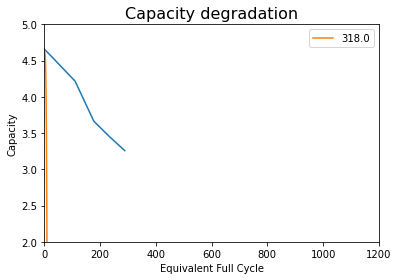

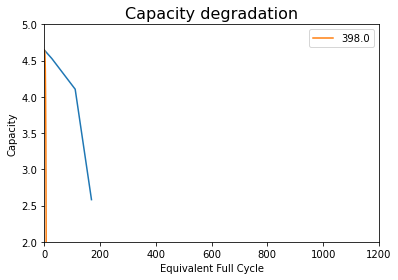

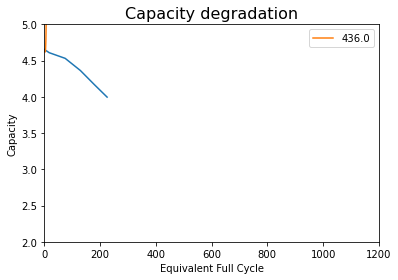

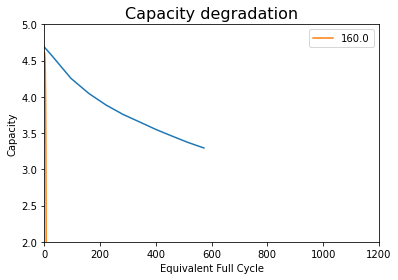

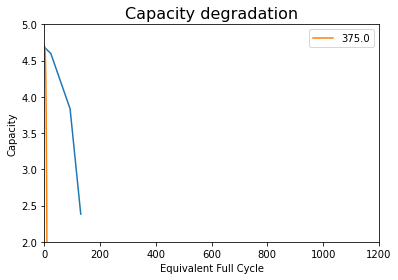

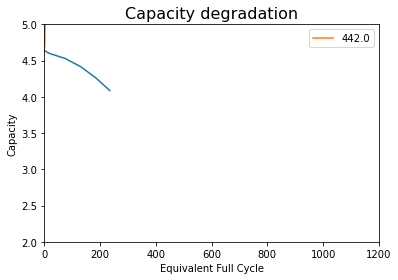

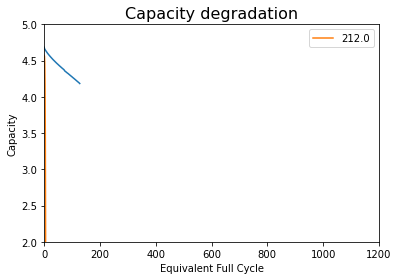

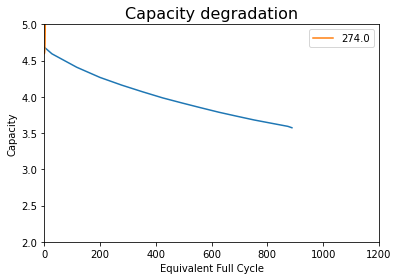

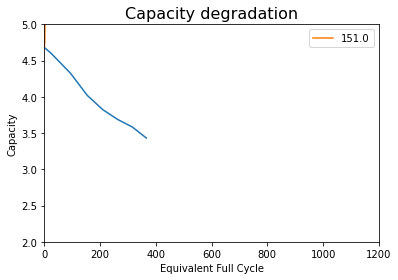

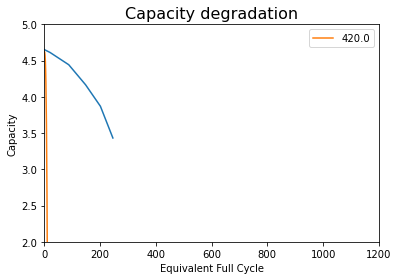

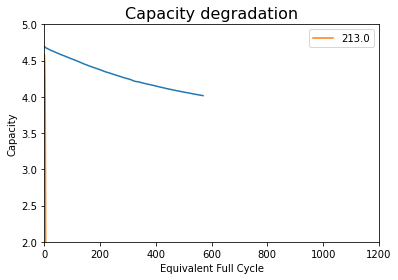

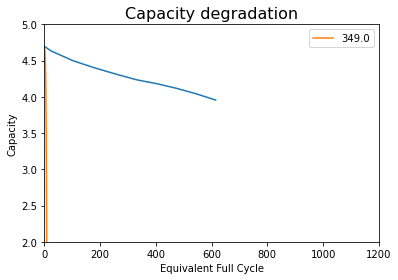

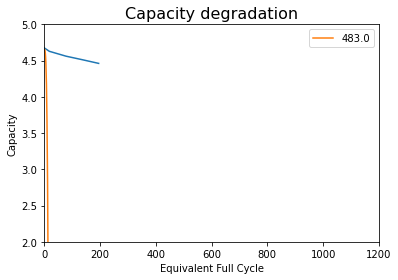

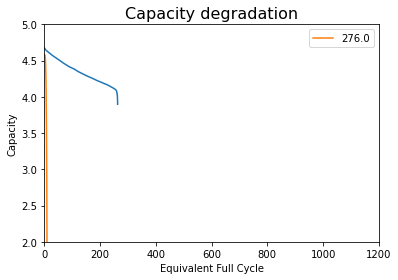

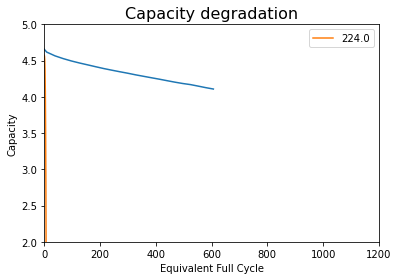

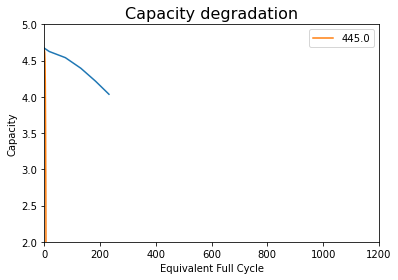

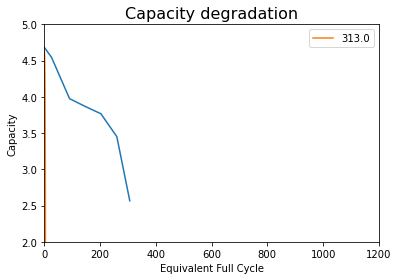

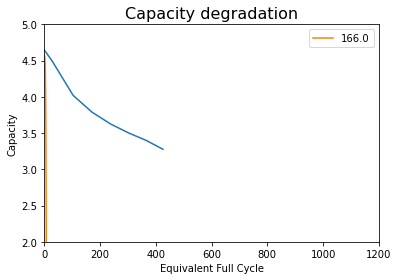

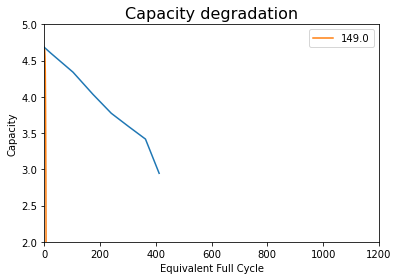

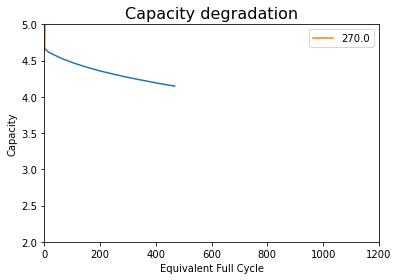

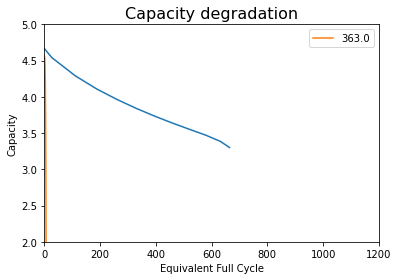

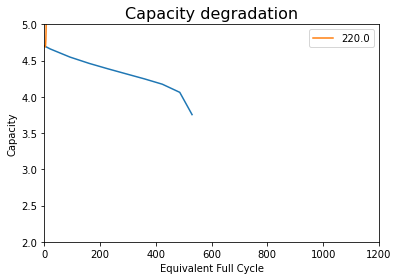

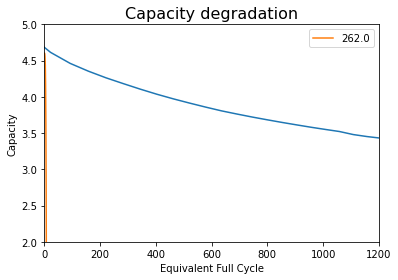

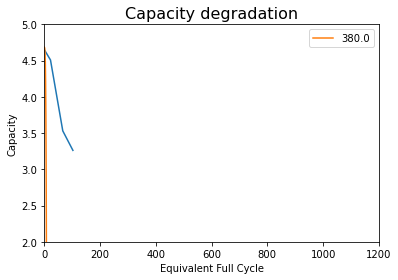

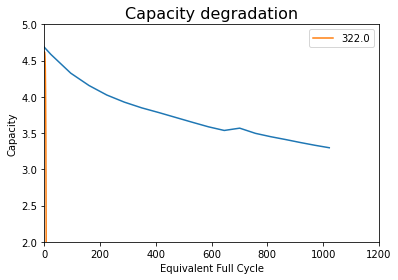

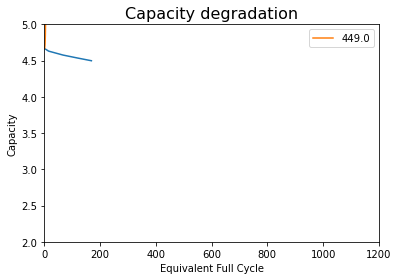

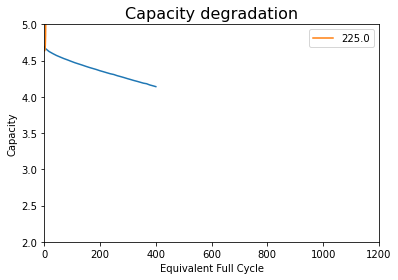

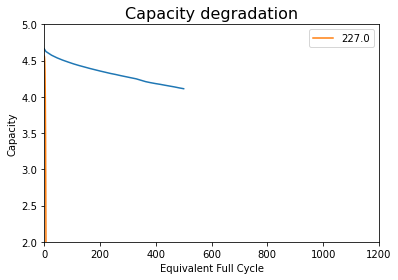

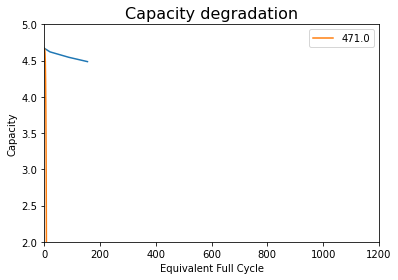

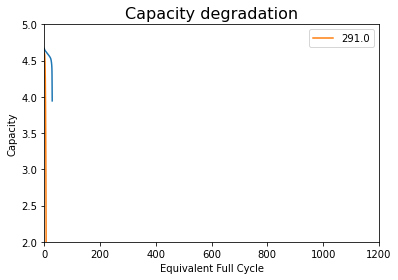

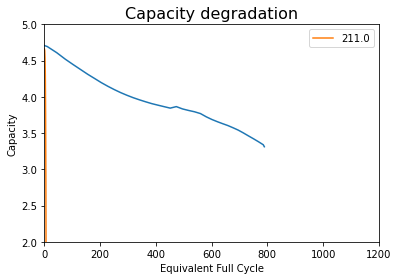

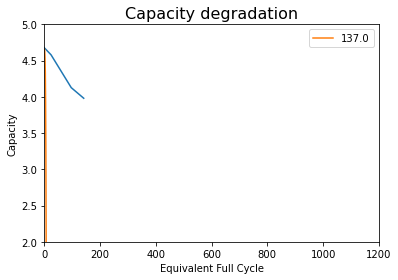

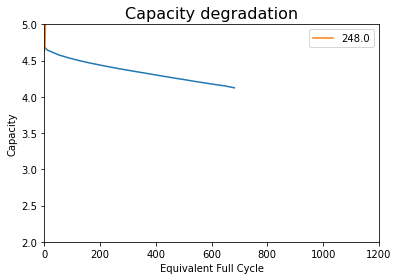

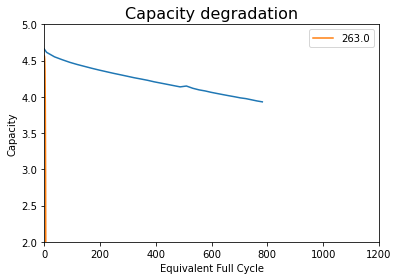

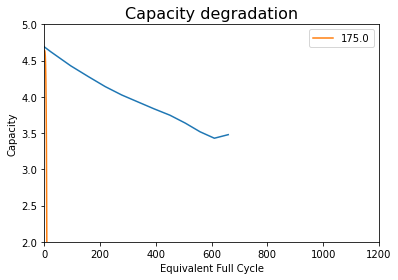

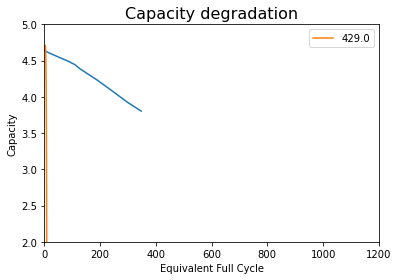

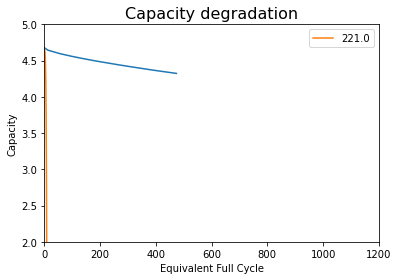

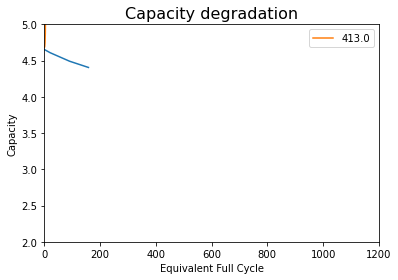

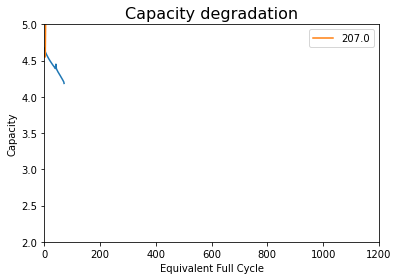

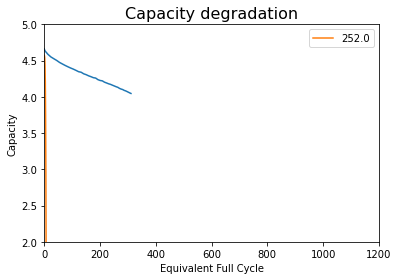

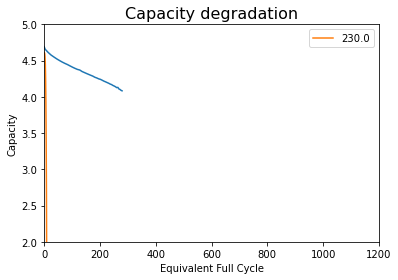

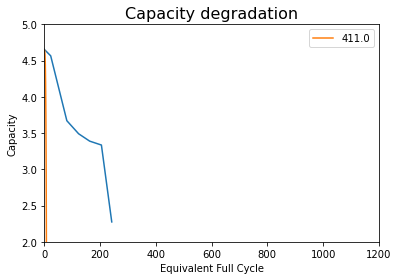

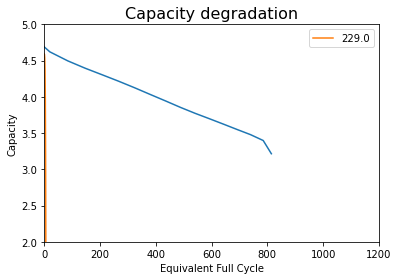

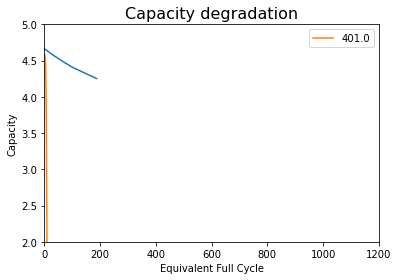

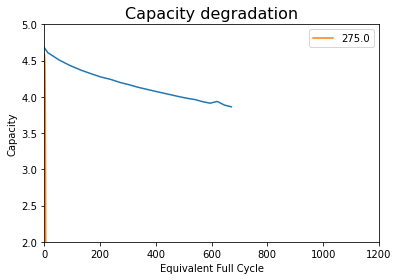

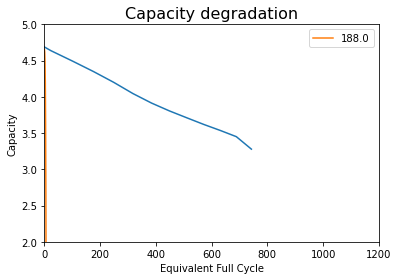

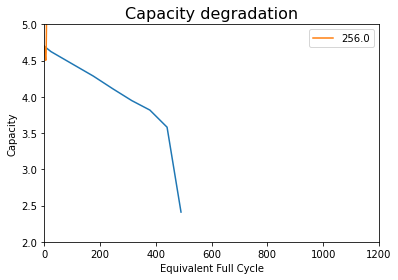

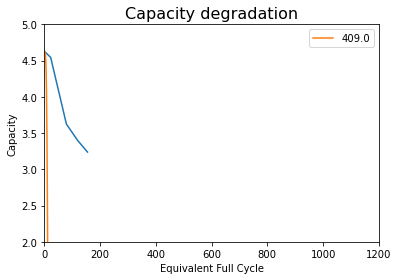

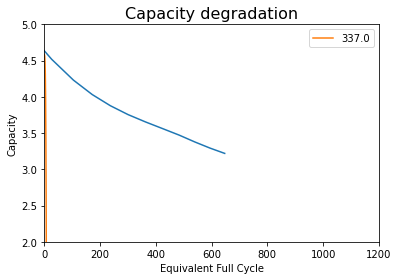

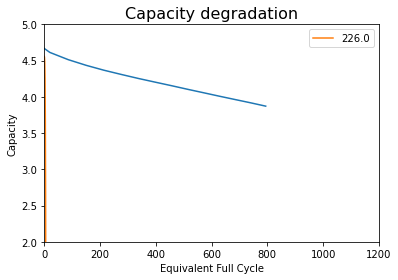

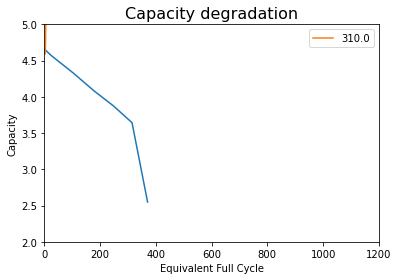

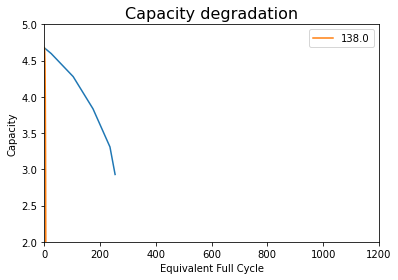

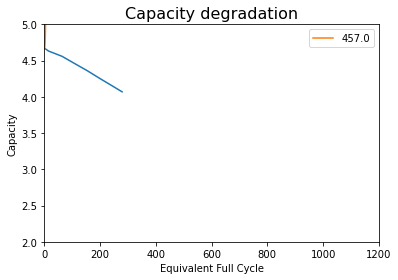

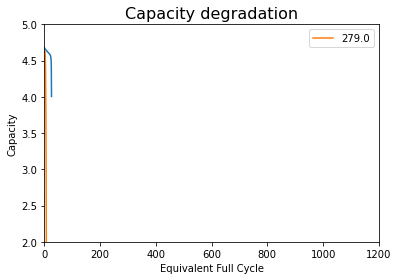

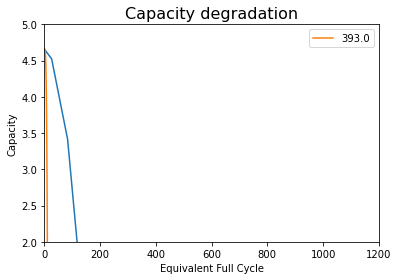

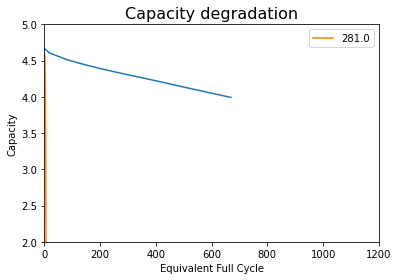

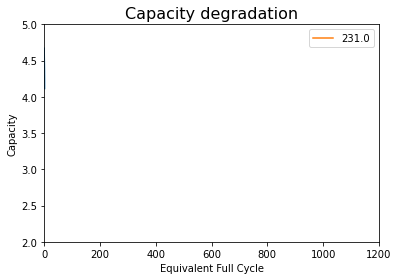

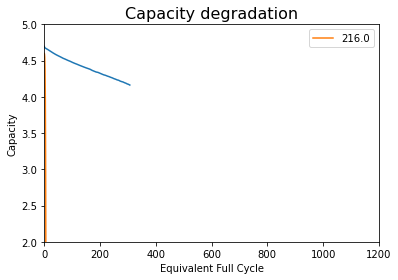

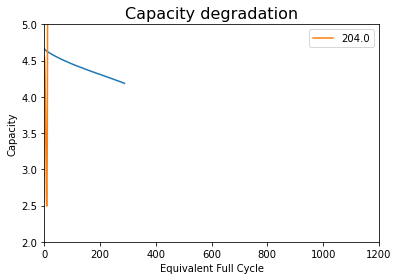

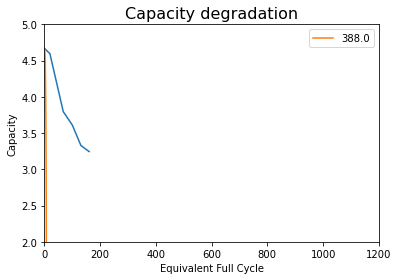

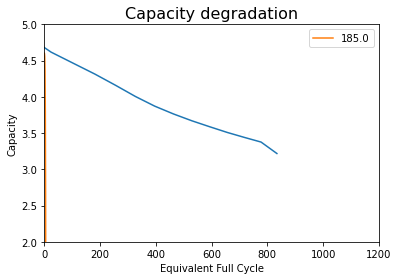

In [418]:
#Predicted Model
for key in test_key:
    inputk = np.array([key])
    plt.figure(key)
    plot_empirical_selected(inputk,l,d,all_metrics_df)
    plot_curve_pred(y_with_key_test,inputk,l,w,all_metrics_df,objective)


/var/folders/_w/m21mbpwj00q_0ghj07dwvwj80000gn/T/ipykernel_58710/2724505573.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(key)


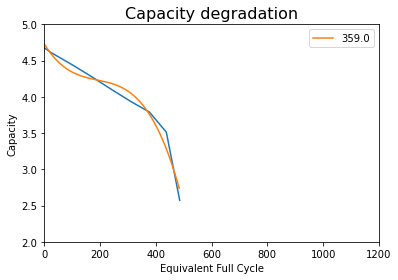

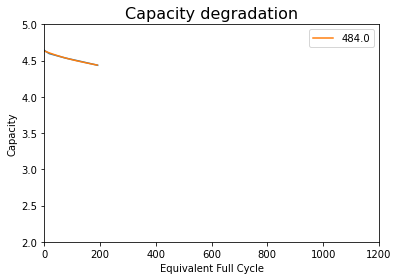

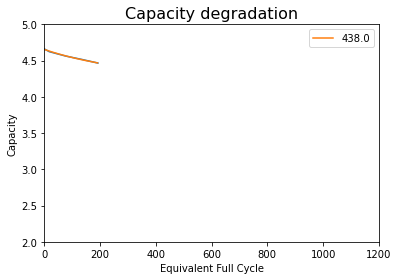

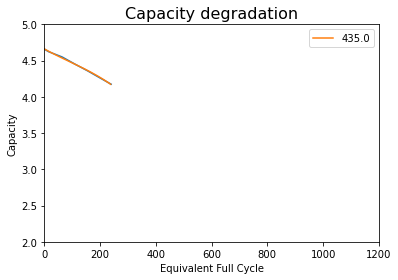

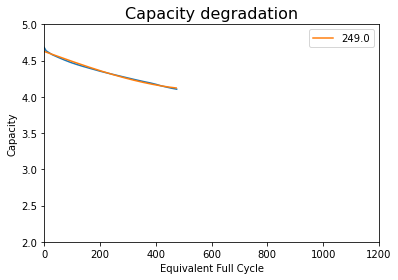

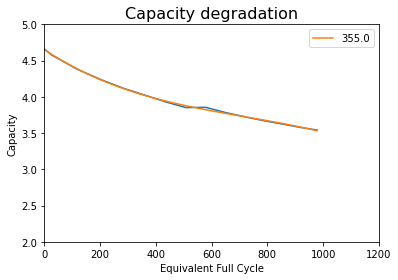

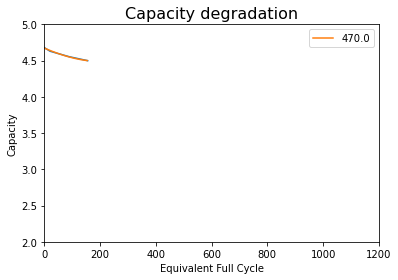

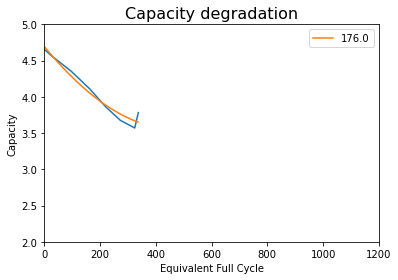

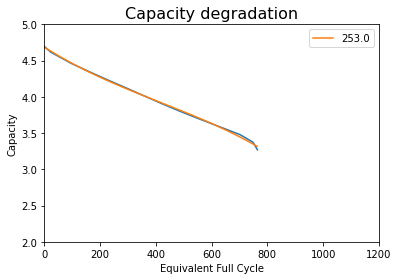

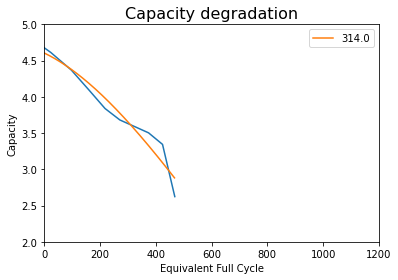

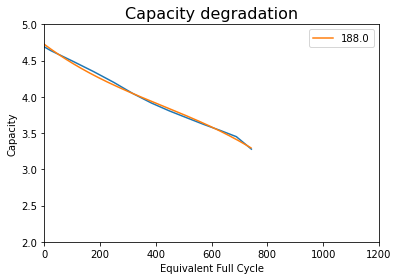

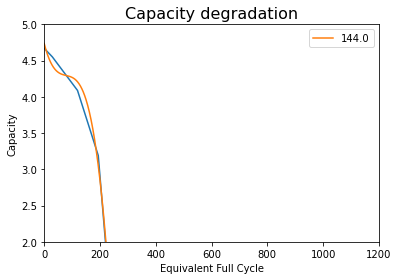

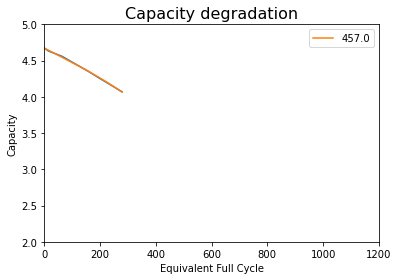

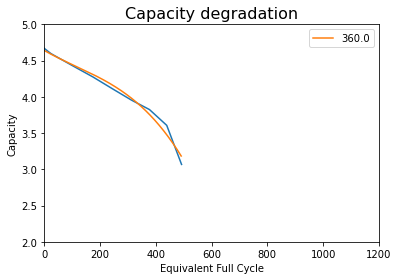

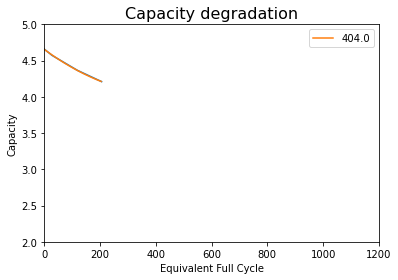

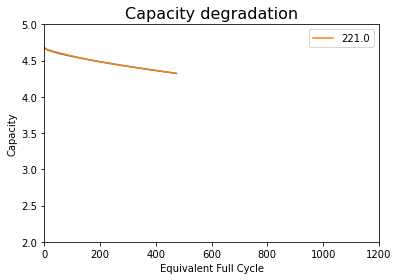

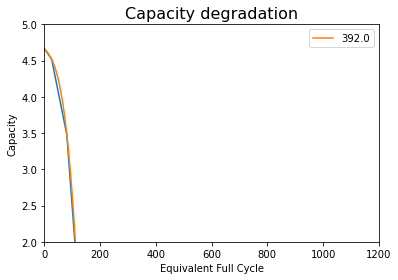

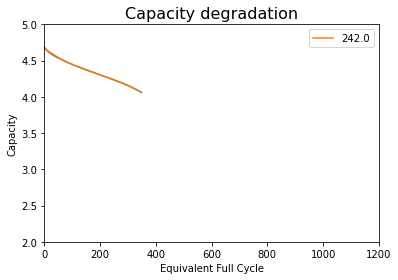

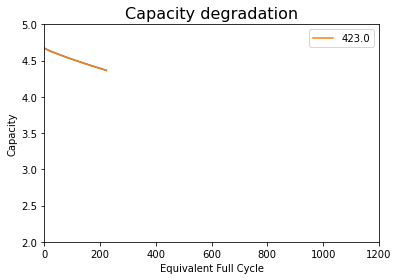

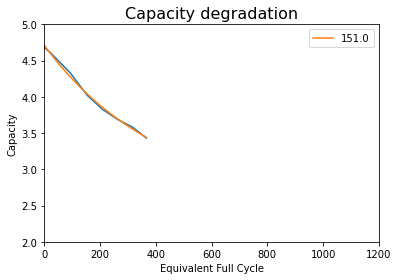

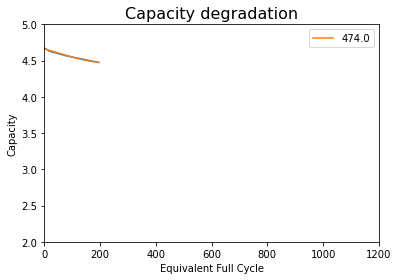

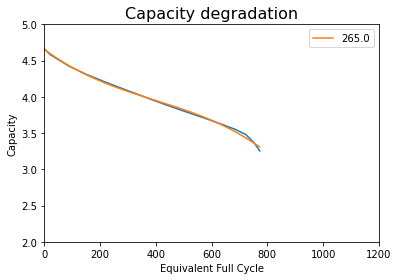

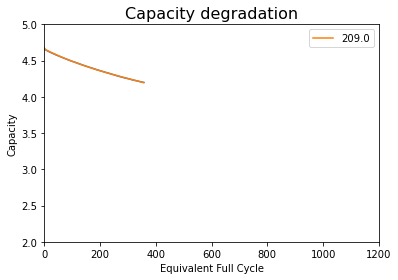

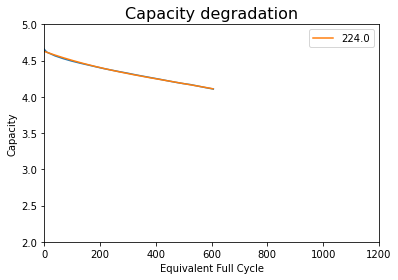

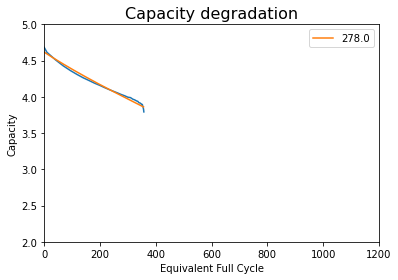

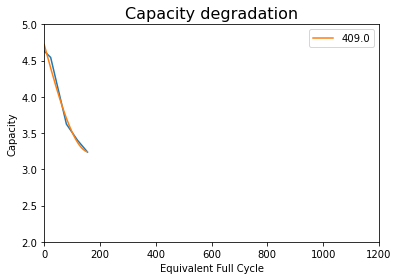

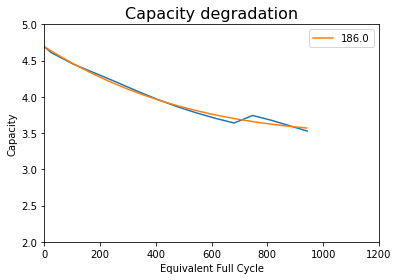

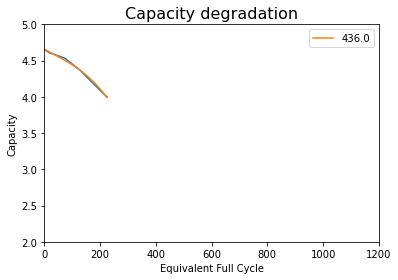

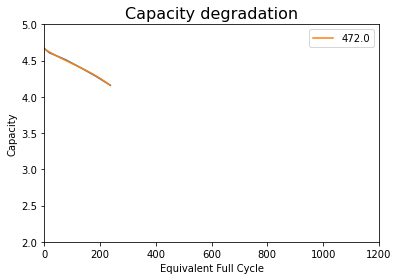

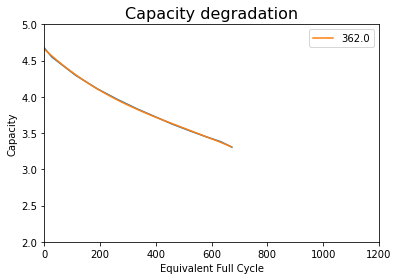

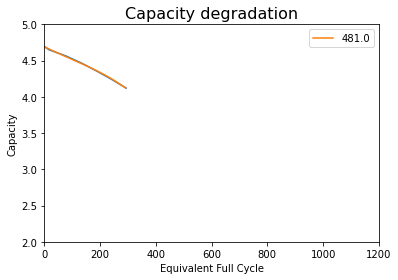

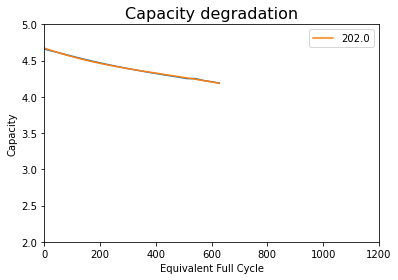

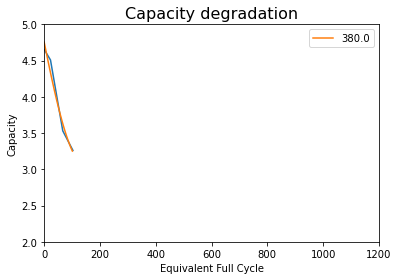

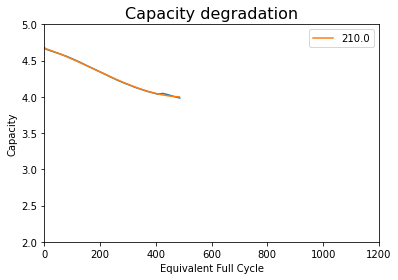

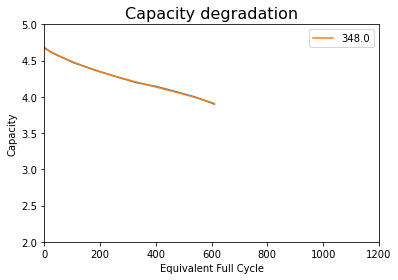

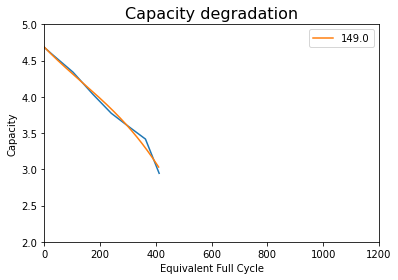

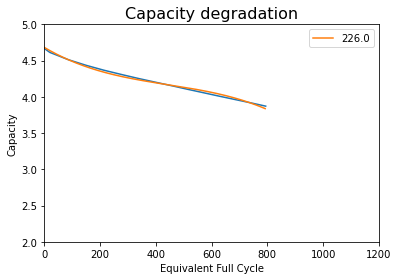

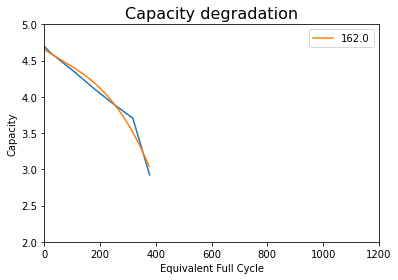

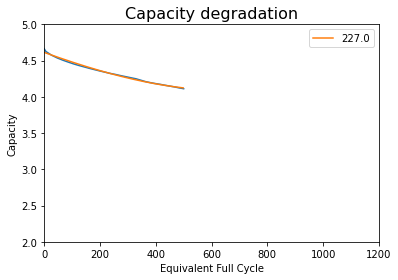

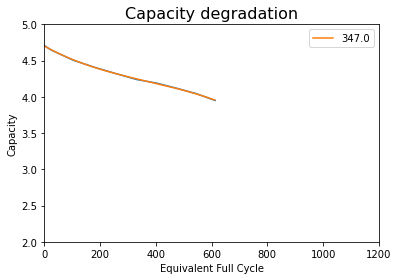

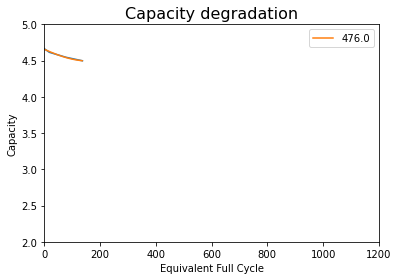

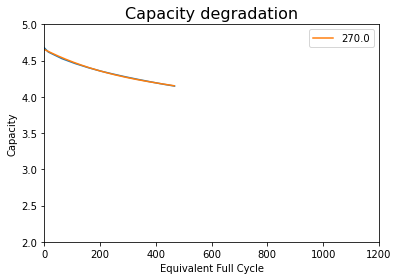

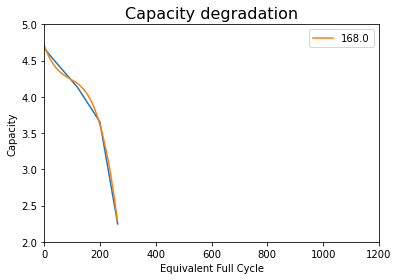

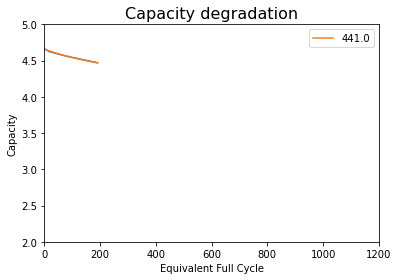

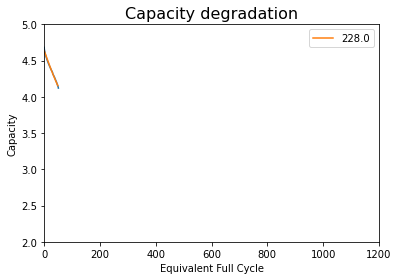

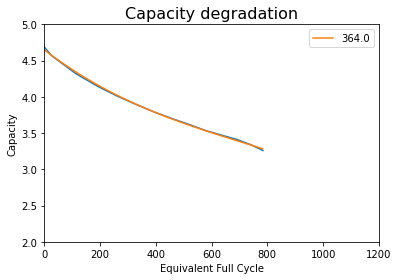

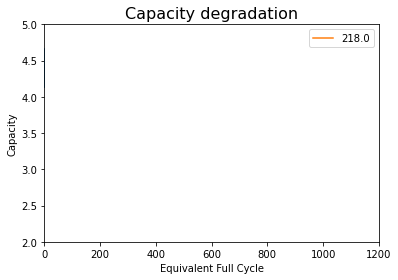

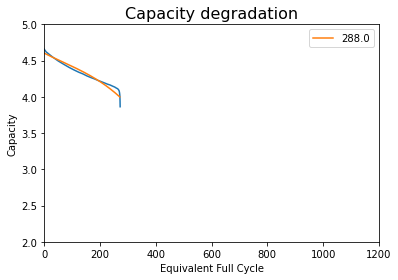

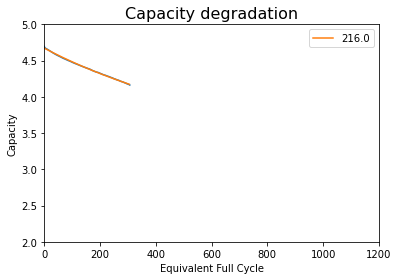

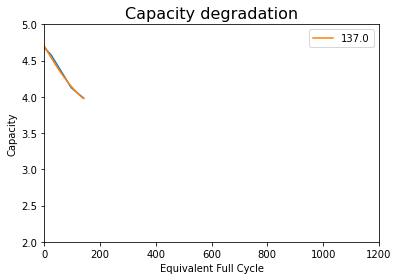

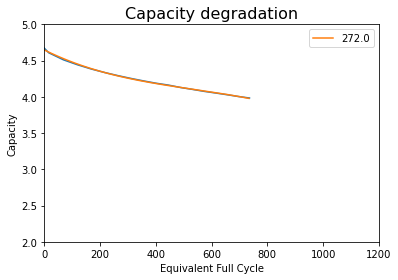

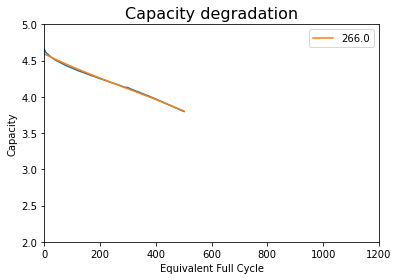

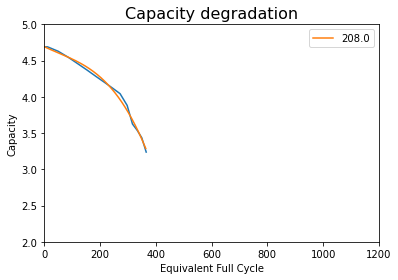

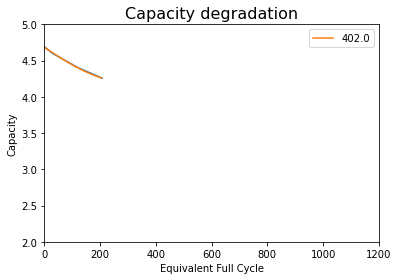

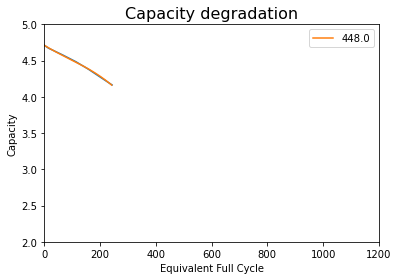

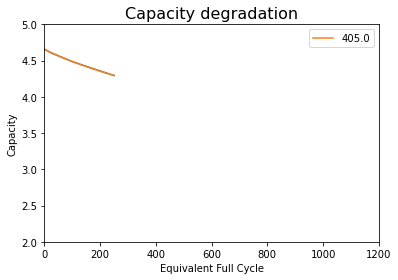

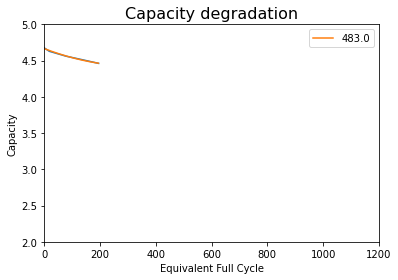

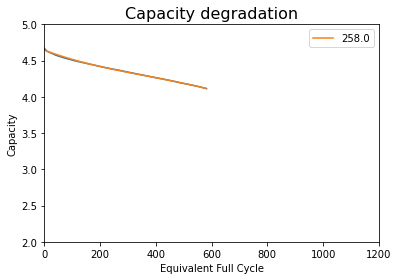

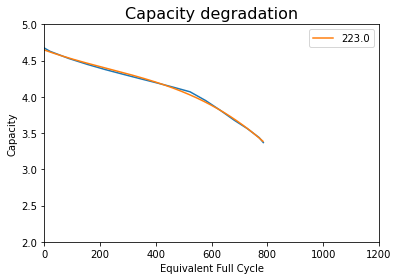

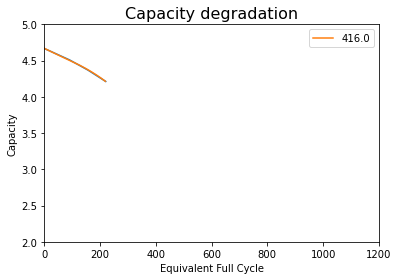

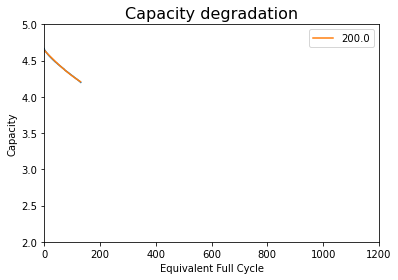

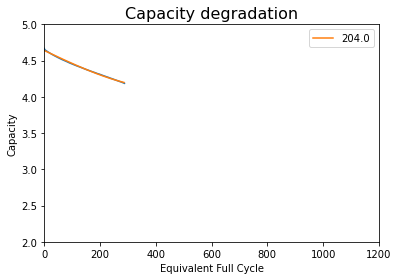

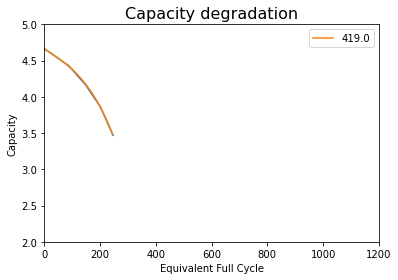

In [401]:
#true curve
for key in test_key:
    inputk = np.array([key])
    plt.figure(key)
    plot_empirical_selected(inputk,l,d,all_metrics_df)
    plot_curve_pred(y_with_key,inputk,l,w,all_metrics_df,objective)
